In [1]:
!pip install llama-index
!pip install llama-index-llms-groq
!pip install llama-index-experimental
!pip install gradio
!pip install fpdf

In [2]:
import pandas as pd
from pydantic import BaseModel, Field, field_validator
from llama_index.core import Settings
from llama_index.llms.groq import Groq
from llama_index.experimental.query_engine import PandasQueryEngine
from google.colab import userdata

# ===== CONFIGURAÇÃO COM PYDANTIC V2 =====
class LLMConfig(BaseModel):
    model: str = Field(..., description="Nome do modelo Groq a ser usado")
    api_key: str = Field(..., description="Chave da API Groq")
    data_url: str = Field(..., description="URL do CSV com os dados")

    @field_validator("data_url")
    @classmethod
    def validar_url(cls, v: str) -> str:
        if not (v.startswith("http://") or v.startswith("https://")):
            raise ValueError("data_url deve começar com http:// ou https://")
        return v

    model_config = {
        "extra": "allow",
        "json_schema_extra": {
            "example": {
                "model": "meta-llama/llama-4-scout-17b-16e-instruct",
                "api_key": "<SUA_CHAVE_AQUI>",
                "data_url": "https://raw.githubusercontent.com/YuriArduino/Estudos_Artificial_Intelligence/refs/heads/Dados/vendas.csv"
            }
        }
    }


# ===== INICIALIZAÇÃO =====
# Obter a chave via Colab userdata
key = userdata.get('Groq_API')

# Configurar
config = LLMConfig(
    model='meta-llama/llama-4-scout-17b-16e-instruct',
    api_key=key,
    data_url='https://raw.githubusercontent.com/YuriArduino/Estudos_Artificial_Intelligence/refs/heads/Dados/vendas.csv'
)

# Carregar CSV
df = pd.read_csv(config.data_url)

# Inicializar LLM via Settings
Settings.llm = Groq(model=config.model, api_key=config.api_key)

# Criar engine de consulta
query_engine = PandasQueryEngine(df=df, verbose=True)

#Obtendo uma resposta mais detalhada

In [3]:
query_engine = PandasQueryEngine(df=df, verbose=True, synthesize_response=True)

Aqui, passamos o dataframe df e utilizamos o parâmetro verbose=True para obter as saídas do que está acontecendo durante a consulta. Também adicionamos o parâmetro synthesize_response=True.

Vamos executar essa célula e testar com uma nova consulta. Podemos criar uma variável chamada response para obter a resposta:

In [4]:
response = query_engine.query('Qual é a avaliação média de cada filial?')

> Pandas Instructions:
```
df.groupby('filial')['avaliacao'].mean().to_dict()
```
> Pandas Output: {'A': 7.027058823529411, 'B': 6.8180722891566266, 'C': 7.072865853658537}


In [5]:
df.groupby('filial')['avaliacao'].mean()

,avaliacao
filial,
A,7.027059
B,6.818072
C,7.072866


In [6]:
print(str(response))

A avaliação média de cada filial é a seguinte:

- Filial A: 7,03
- Filial B: 6,82
- Filial C: 7,07

Esses valores são calculados com base na média das avaliações de cada filial.


##Formatando o texto da resposta

In [8]:
import textwrap

Em seguida, vamos criar uma função chamada formatar_texto, que receberá a resposta. Em seguida, criaremos uma variável chamada texto. Se fizermos um teste e escrevermos response.response, obteremos apenas a resposta, sem as instruções. Por isso, a variável texto será igual a response.response.

Criaremos depois um texto_formatado que será igual ao textwrap.fill(). Dentro dos parênteses, colocaremos o texto e a largura desejada para o texto. Testaremos com width=100. Por fim, traremos um print do texto formatado:

In [10]:
response.response

'A avaliação média de cada filial é a seguinte:\n\n- Filial A: 7,03\n- Filial B: 6,82\n- Filial C: 7,07\n\nEsses valores são calculados com base na média das avaliações de cada filial.'

In [12]:
#Função formatar texto
def formatar_texto(response):
    texto = response.response
    texto_formatado = textwrap.fill(texto, width=100)
    print(texto_formatado)

In [11]:
formatar_texto(response)

A avaliação média de cada filial é a seguinte:  - Filial A: 7,03 - Filial B: 6,82 - Filial C: 7,07
Esses valores são calculados com base na média das avaliações de cada filial.


---


###Para saber mais: especificando detalhes nas consultas


No vídeo anterior, discutimos como utilizar o **PandasQueryEngine** para obter respostas mais detalhadas e explicativas, configurando o parâmetro `synthesize_response=True`.

Por exemplo, aplicamos o seguinte código para investigar a **avaliação média de cada filial** da Zoop:

```python
query_engine = PandasQueryEngine(df=df, verbose=True, synthesize_response=True)
response = query_engine.query('Qual é a avaliação média de cada filial?')
```

Com essa consulta, obtivemos a resposta:

> A avaliação média de cada filial é a seguinte: a filial A tem uma avaliação média de 7.03, a filial B tem uma avaliação média de 6.82 e a filial C tem uma avaliação média de 7.07.

Essa resposta fornece uma visão geral das avaliações médias. Contudo, podemos **aprimorar a análise** ao ordenar as filiais pela média, do maior para o menor valor, destacando rapidamente as filiais com melhor desempenho.

Para isso, podemos fazer uma consulta mais específica:

```python
response = query_engine.query('Qual é a avaliação média de cada filial? Ordene da maior para a menor')
print(response.response)
```

A nova resposta é:

> A avaliação média de cada filial, em ordem decrescente, é a seguinte: a filial C tem uma avaliação média de 7.07, a filial A tem uma avaliação média de 7.03, e a filial B tem uma avaliação média de 6.82.

Essa ordenação traz **valor adicional à análise**, permitindo identificar rapidamente as filiais com melhores avaliações e tomar decisões mais informadas sobre estratégias de melhoria para cada unidade.

💡 **Dica:** Para enriquecer ainda mais sua experiência com o PandasQueryEngine, teste outras consultas e explore diferentes formas de detalhar as respostas.

---



#Obtendo gráficos

A biblioteca possui uma função chamada plot, com a qual conseguimos obter histogramas, boxplots, gráficos de barras, entre outros.

Embora não seja tão eficiente e customizável quanto as bibliotecas Matplotlib ou Seaborn, que são as mais usadas para visualização de dados, ainda assim, ela consegue plotar gráficos e mostrar resultados interessantes.

Podemos testar isso e verificar se conseguimos. Vamos criar uma nova variável chamada response:

In [14]:
response = query_engine.query('Você pode exibir a distribuição das avaliações?')

> Pandas Instructions:
```
df['avaliacao'].value_counts()
```
> Pandas Output: avaliacao
6.0     26
6.6     24
9.5     22
4.2     22
5.1     21
        ..
5.3     11
8.3     11
4.0     11
4.6      8
10.0     5
Name: count, Length: 61, dtype: int64


In [15]:
df.avaliacao.value_counts()

,count
avaliacao,
6.0,26
6.6,24
9.5,22
4.2,22
5.1,21
...,...
5.3,11
8.3,11
4.0,11


In [16]:
formatar_texto(response)

Claro, posso exibir a distribuição das avaliações com base nos dados fornecidos.  A distribuição das
avaliações é a seguinte:  - 6.0: 26 ocorrências - 6.6: 24 ocorrências - 9.5: 22 ocorrências - 4.2:
22 ocorrências - 5.1: 21 ocorrências - ... (outras avaliações com menos ocorrências)  A lista
completa de avaliações e suas respectivas ocorrências é:  ``` avaliacao 6.0      26 6.6      24 9.5
22 4.2      22 5.1      21 ... 5.3      11 8.3      11 4.0      11 4.6       8 10.0      5 Name:
count, Length:61, dtype: int64 ```  Essa distribuição mostra que as avaliações variam amplamente,
com algumas avaliações mais altas (como 6.0, 6.6 e 9.5) tendo mais ocorrências do que as avaliações
mais baixas ou extremas (como 4.0, 4.6 e 10.0). A grande variedade de avaliações e a diferença na
frequência de cada uma delas indicam uma diversidade significativa nas opiniões ou classificações
fornecidas.


###Obtendo a resposta em gráfico

> Pandas Instructions:
```
df['avaliacao'].plot.hist(bins=10, figsize=(10,6))
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


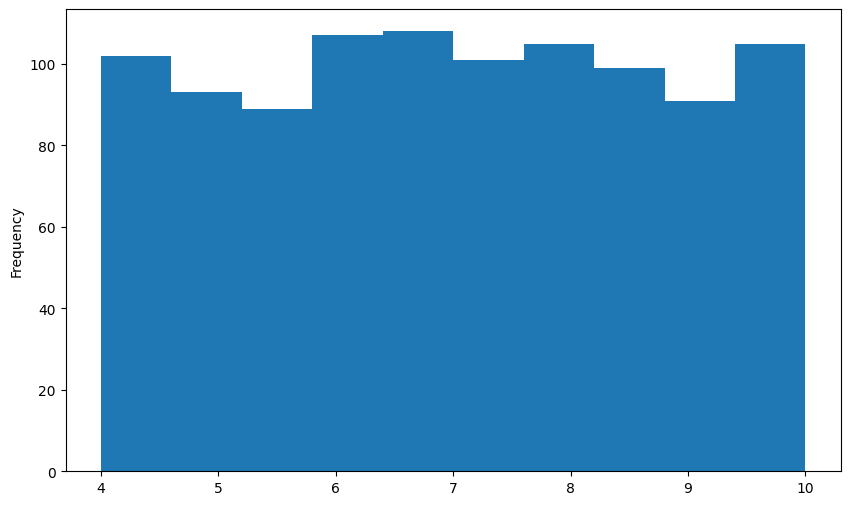

In [17]:
response = query_engine.query('Você pode plotar a distribuição das avaliações?')

Ele utilizou a instrução para pegar o DataFrame, a coluna avaliacao, e usou a função plot com o tipo de gráfico kind='hist'. Perfeito, ele acertou.

Podemos até pedir a resposta formatada novamente:

In [18]:
formatar_texto(response)

Sim, posso plotar a distribuição das avaliações. A distribuição pode ser visualizada através de um
histograma.   O histograma das avaliações está distribuído da seguinte forma:  [ Informação do
gráfico: um histograma com 10 bins, tamanho da figura 10x6 ]  Com esse gráfico, é possível ter uma
noção clara de como as avaliações estão distribuídas, ajudando a identificar tendências, padrões ou
outliers nos dados.   O código utilizado para gerar esse gráfico foi: ```python
df['avaliacao'].plot.hist(bins=10, figsize=(10,6)) ``` Esse comando cria um histograma com 10
intervalos (bins) para agrupar as avaliações e define o tamanho da figura como 10x6 polegadas,
facilitando a visualização e análise da distribuição das avaliações.


##Obtendo um gráfico mais complexo

> Pandas Instructions:
```
df.groupby('tipo_produto')['total'].sum().sort_values().plot(kind='barh')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


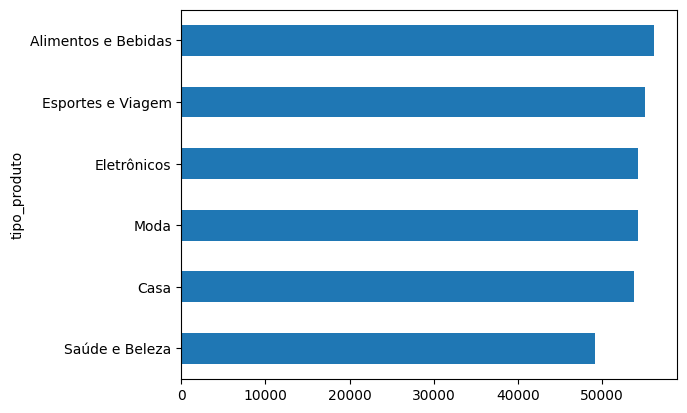

In [19]:
response = query_engine.query('''
Você pode plotar o valor total por tipo de produto, ordenando do menor para o maior e mantendo as barras na horizontal?
''')

Ele agrupou o DataFrame pelo tipo de produto, somou o valor total faturado com cada tipo, ordenou e plotou usando o tipo de barra horizontal. O resultado mostra alimentos e bebidas, esportes e viagens, eletrônicos, moda, casa, e o menor valor total, saúde e beleza.

No entanto, dependendo de como formulamos a pergunta, pode ocorrer algo diferente. Vamos imprimir a resposta:

In [20]:
formatar_texto(response)

Sim, é possível plotar o valor total por tipo de produto, ordenando do menor para o maior e mantendo
as barras na horizontal.   Para fazer isso, você pode usar a biblioteca Pandas e seguir os passos
abaixo:  1. Agrupe os dados por 'tipo_produto' e some os valores de 'total'. 2. Ordene os valores em
ordem crescente. 3. Plote os dados usando o tipo de gráfico de barras horizontais ('barh').  Aqui
está um exemplo de código que realiza isso:  ```python import pandas as pd import matplotlib.pyplot
as plt  # Supondo que df seja o seu DataFrame
df.groupby('tipo_produto')['total'].sum().sort_values().plot(kind='barh') plt.title('Valor Total por
Tipo de Produto') plt.xlabel('Valor Total') plt.ylabel('Tipo de Produto') plt.show() ```  Esse
código irá gerar um gráfico de barras horizontais, onde os tipos de produtos estão ordenados do
menor para o maior valor total. As barras representam os valores totais para cada tipo de produto.
Lembre-se de que você precisa ter o DataFrame `df` com as colunas

Se, em vez de perguntar, formos mais diretos, dizendo algo como "Plote o valor total por tipo de produto, ordenando do menor para o maior e mantendo as barras na horizontal", sem a interrogação, o gráfico será gerado da mesma forma.

> Pandas Instructions:
```
df.groupby('tipo_produto')['total'].sum().sort_values().plot(kind='barh')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


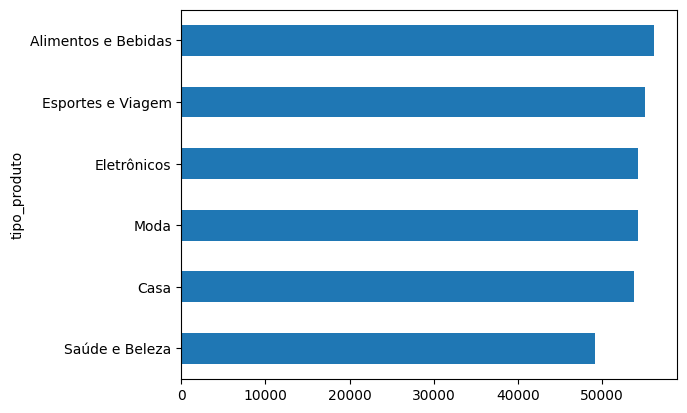

In [21]:
response = query_engine.query('''Plote o valor total por tipo de produto,
ordenando do menor para o maior e mantendo as barras na horizontal''')

In [22]:
formatar_texto(response)

Para plotar o valor total por tipo de produto, ordenando do menor para o maior e mantendo as barras
na horizontal, você pode utilizar a biblioteca Pandas em Python. Aqui está um exemplo de código que
realiza isso:  ```python import pandas as pd import matplotlib.pyplot as plt  # Supondo que você
tenha um DataFrame chamado 'df' # Certifique-se de que as colunas 'tipo_produto' e 'total' existam
no seu DataFrame  # Agrupe os dados por 'tipo_produto', some os valores de 'total', ordene e plote
df.groupby('tipo_produto')['total'].sum().sort_values().plot(kind='barh')  # Mostrar o plot
plt.show() ```  Este código irá gerar um gráfico de barras horizontais, onde cada barra representa
um tipo de produto, ordenado do menor para o maior valor total.  Se você quiser uma resposta mais
detalhada:  - **Passos**:   1. **Agrupamento**: Agrupe os dados por tipo de produto usando
`df.groupby('tipo_produto')`.   2. **Soma**: Some os valores totais para cada tipo de produto com
`['total'].sum()`.   3. **O

#Direcionando o idioma das respostas

Conseguimos gerar gráficos utilizando essa ferramenta, o que foi muito interessante. No entanto, dependendo da forma como solicitamos algo ao modelo, ele pode responder em outro idioma, como o inglês. Nosso objetivo é manter a consistência para que os resultados sejam no idioma que desejamos trabalhar, que, neste caso, é o português.

Vamos testar fazendo outra pergunta para verificar se ele continuará respondendo em inglês. Podemos fazer o seguinte:

In [23]:
response = query_engine.query('Qual é o método de pagamento mais utilizado em cada filial?')
print(response.response)

> Pandas Instructions:
```
```python
df.groupby('filial')['forma_pagamento'].agg(lambda x: x.mode().iloc[0]).to_dict()
```
```
> Pandas Output: {'A': 'Carteira Digital', 'B': 'Carteira Digital', 'C': 'Dinheiro'}
Em cada uma das filiais, o método de pagamento mais utilizado varia. 

- Na filial A, o método mais utilizado é **Carteira Digital**.
- Na filial B, também é **Carteira Digital**.
- Já na filial C, o método mais usado é **Dinheiro**.


In [24]:
df.groupby('filial')['forma_pagamento'].value_counts().groupby('filial').idxmax()

,count
filial,
A,"(A, Carteira Digital)"
B,"(B, Carteira Digital)"
C,"(C, Dinheiro)"


In [25]:
response = query_engine.query('Qual é o método de pagamento mais utilizado em cada filial? Responda em português BR')
print(response.response)

> Pandas Instructions:
```
```
df.groupby('filial')['forma_pagamento'].agg(lambda x: x.mode().iloc[0]).to_dict()
```
```
> Pandas Output: {'A': 'Carteira Digital', 'B': 'Carteira Digital', 'C': 'Dinheiro'}
Em cada uma de nossas filiais, o método de pagamento mais utilizado varia. 

- Na filial A, o método mais utilizado é **Carteira Digital**.
- Na filial B, também temos **Carteira Digital** como o método preferido.
- Já na filial C, o pagamento em **Dinheiro** é o mais comum.

Essas informações refletem os padrões de pagamento observados em nossas operações.


In [26]:
df.groupby('filial')['forma_pagamento'].value_counts().groupby('filial').idxmax()

,count
filial,
A,"(A, Carteira Digital)"
B,"(B, Carteira Digital)"
C,"(C, Dinheiro)"


In [28]:
df.groupby('filial')['forma_pagamento'].value_counts()

filial  forma_pagamento  
A       Carteira Digital     126
        Dinheiro             110
        Cartão de Crédito    104
B       Carteira Digital     113
        Dinheiro             110
        Cartão de Crédito    109
C       Dinheiro             124
        Carteira Digital     106
        Cartão de Crédito     98
Name: count, dtype: int64

Executando o código, verificamos que na filial A, a carteira digital tem 126 ocorrências, na filial B, 113 na carteira digital, e na filial C, o dinheiro tem 124. Tudo está correto.

Conseguimos direcionar o idioma, mas não queremos ter que fazer isso manualmente toda vez. Desejamos algo automatizado e prático, para que o time de dados da Zoop tenha uma IA eficiente e customizável conforme suas necessidades.

Em vez de usar o Pandas Query Engine da forma atual, podemos criar um pipeline que executa várias etapas até chegar à resposta final. Podemos definir o idioma de saída, como o modelo deve responder a determinadas perguntas e passar detalhes para os prompts que serão executados. Existem formas de customizar essa ferramenta para obter resultados mais interessantes.

#Exercício: obtendo respostas detalhadas
Próxima Atividade

Nesta atividade, você continuará a aplicar o que aprendeu sobre consultas em DataFrames utilizando o PandasQueryEngine. Recentemente, adicionamos o parâmetro synthesize_response=True para obter respostas com explicações, permitindo uma análise mais rica e compreensível dos dados.

Agora, explore os seguintes pontos:

*Quais filiais têm uma avaliação média acima de 7?

*Crie um gráfico do tipo boxplot das avaliações por filial para comparar a distribuição desses dados.

*Qual é a média de gasto por tipo de cliente?


Essas consultas te ajudarão a identificar filiais com melhor desempenho, entender a variação nas avaliações de cada filial e observar o comportamento de gasto diferenciado entre tipos de clientes.

Se você tiver alguma dúvida, consulte a opinião da pessoa instrutora.

Resposta para a 1ª query ('Quais filiais têm uma avaliação média acima de 7?'):
> Pandas Instructions:
```
df[df['avaliacao'] > 7]['filial'].unique()
```
> Pandas Output: ['A' 'C' 'B']
Based on the query results, the branches with an evaluation above 7 are:

The branches 'A', 'C', and 'B' have evaluations above 7.
--------------------
Resposta para a 2ª query('Crie um gráfico do tipo boxplot das avaliações por filial para comparar a distribuição desses dados.'):
> Pandas Instructions:
```
```python
df.boxplot(column='avaliacao', by='filial')
```
```
> Pandas Output: Axes(0.1,0.15;0.8x0.75)
To create a boxplot graphic that compares the data distribution of evaluations by branches, you can utilize the pandas library in Python. The boxplot will provide a visual representation of the distribution of evaluations across different branches, helping to identify outliers, variability, and central tendency.

Here's a step-by-step guide on how to accomplish this:

### Step 1: Import Necessary Lib

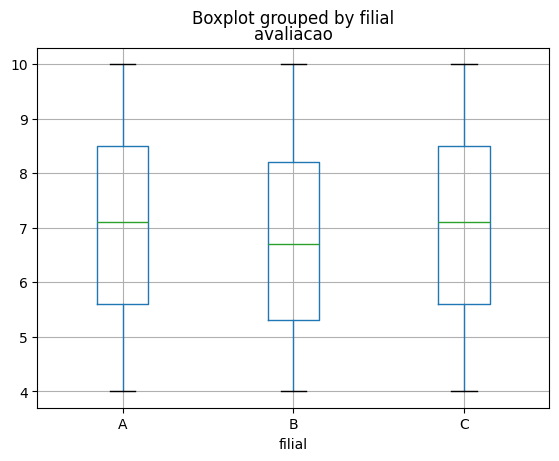

In [38]:
all_exercise_responses = []

print("Resposta para a 1ª query ('Quais filiais têm uma avaliação média acima de 7?'):")
exercise_q1 = query_engine.query('Which branches have a evaluation above 7?')
print(exercise_q1.response)
all_exercise_responses.append(exercise_q1)
print("-" * 20)

print("Resposta para a 2ª query('Crie um gráfico do tipo boxplot das avaliações por filial para comparar a distribuição desses dados.'):")
exercise_q2 = query_engine.query('Create a bloxplot graphic about evaluations by branches comparing the data distribution')
print(exercise_q2.response)
all_exercise_responses.append(exercise_q2)
print("-" * 20)

print("Resposta para a 3ª query('Qual é a média de gasto por tipo de cliente?'):")
exercise_q3 = query_engine.query('What is the average spend by customer type?')
print(exercise_q3.response)
all_exercise_responses.append(exercise_q3)
print("-" * 20)

print("\nTodas as respostas dos exercícios foram salvas em:  'all_exercise_responses' list.")